In [1]:
import sys

sys.path.append("../")

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from mlresearch.utils import set_matplotlib_style
from algorec.recourse import NFeatureRecourse
from algorec.populations import BasePopulation
from algorec.environments import BankLoanApplication3

In [3]:
set_matplotlib_style(16)

# Some variables to define the problem
RNG_SEED = 42
N_CONTINUOUS = 2
N_CAT = 0
N_AGENTS = 100

# Environment variables
N_LOANS = 10  # np.array([20, 1, 10, 30, 0, 5, 50, 10, 40])
ADAPTATION = .5  # 0.5  # np.array([.2, .1, .3, .25, .1, .4, .05, .05, .2])
NEW_AGENTS = 10  # np.array([40, 10, 50, 5, 0, 100, 0, 0, 20])

# TODO: end and stop from updating when population becomes too small

# Generate data and fit regression
continuous = [f"f_{i}" for i in range(N_CONTINUOUS)]
categorical = [f"cat_{i}" for i in range(N_CAT)]
rng = np.random.default_rng(RNG_SEED)
df = pd.DataFrame(
    rng.random((N_AGENTS, N_CONTINUOUS)),
    columns=[f"f_{i}" for i in range(N_CONTINUOUS)],
)

for i in range(N_CAT):
    df[f"cat_{i}"] = rng.integers(0, 2, N_AGENTS)

y = rng.integers(0, 2, N_AGENTS)
lr = LogisticRegression().fit(df, y)

In [4]:
# Define the necessary components to run simulation
population = BasePopulation(df, categorical=categorical)
population.action_set_.ub = [1, 1]
recourse = NFeatureRecourse(lr, n_features=2)
environment = BankLoanApplication3(
    population,
    recourse,
    n_loans=N_LOANS,
    adaptation=ADAPTATION,
    new_agents=NEW_AGENTS,
    random_state=RNG_SEED,
)

environment.run_simulation(20)

<Axes: title={'center': 'Population scores over 21 time steps'}, xlabel='Step', ylabel='Score'>

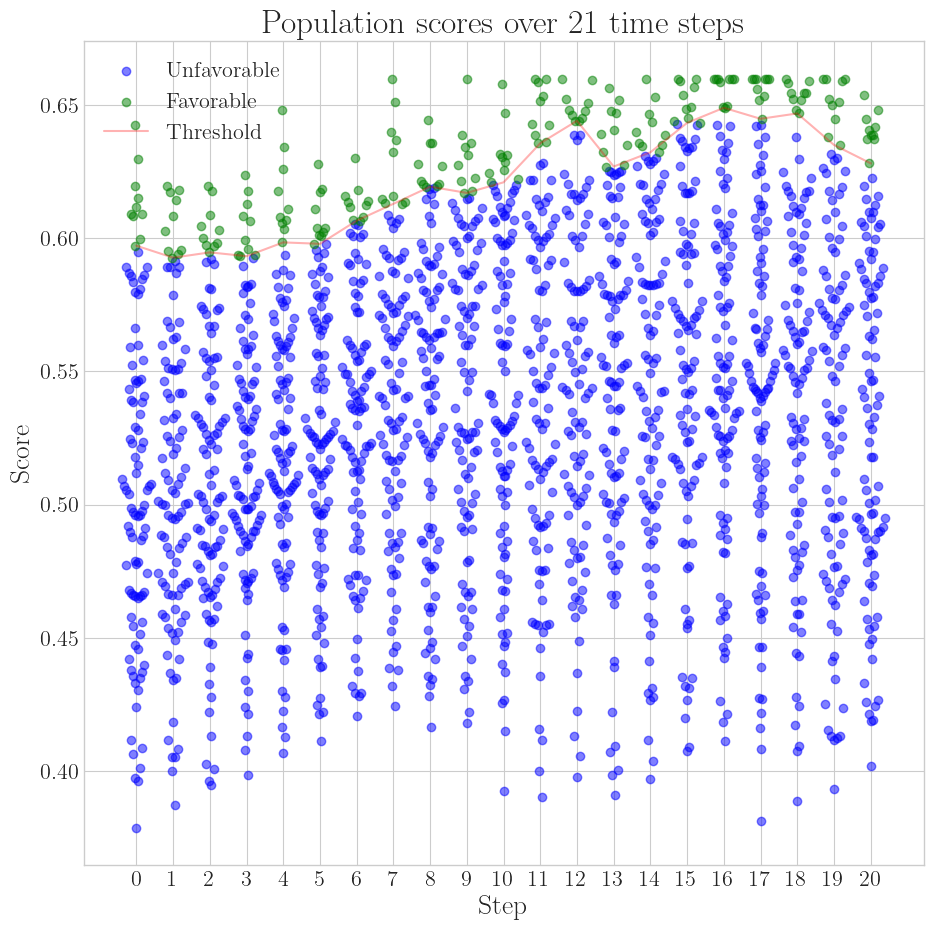

In [5]:
environment.plot.agent_scores()

<Axes: title={'center': 'Population at t=4'}, xlabel='f_0', ylabel='f_1'>

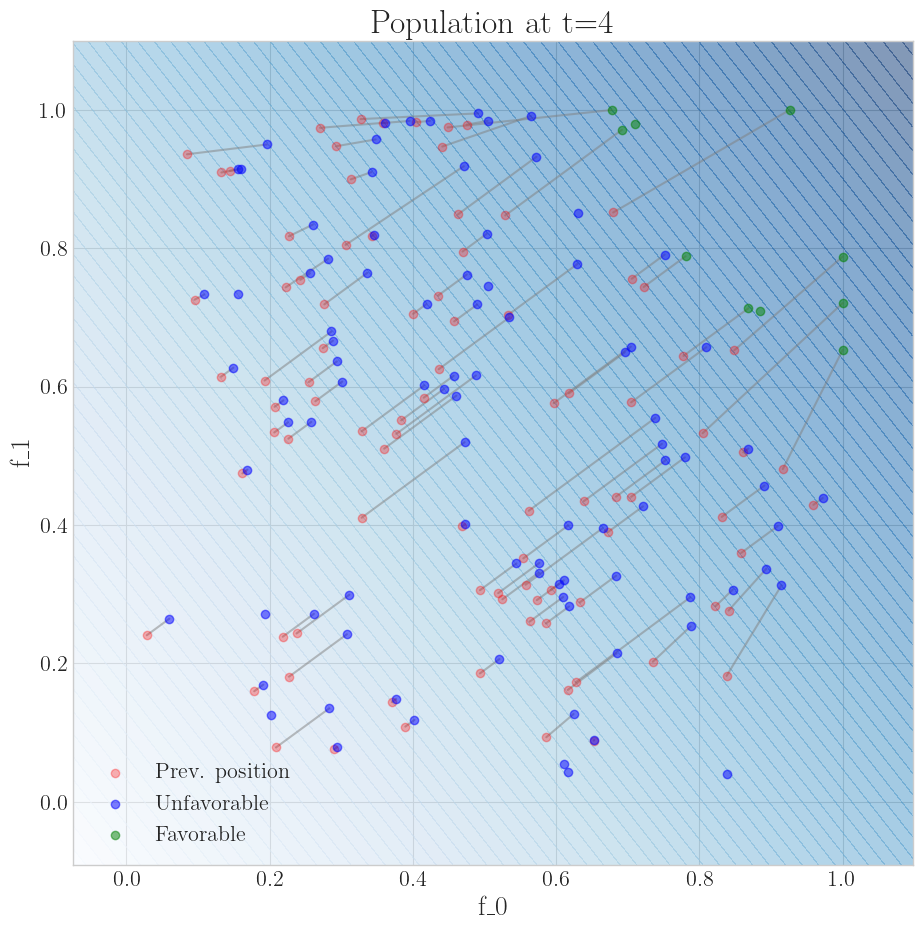

In [6]:
environment.plot.scatter(4)

(array([ 4.,  5., 12., 14., 20., 10., 13., 11.,  8.,  3.]),
 array([0.37874517, 0.40511149, 0.43147781, 0.45784413, 0.48421045,
        0.51057677, 0.53694309, 0.56330941, 0.58967573, 0.61604205,
        0.64240837]),
 <BarContainer object of 10 artists>)

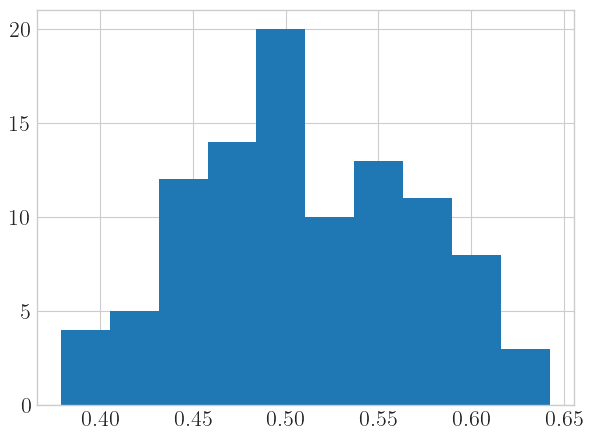

In [7]:
environment.plot.scores_histogram(0)

<Axes: ylabel='Density'>

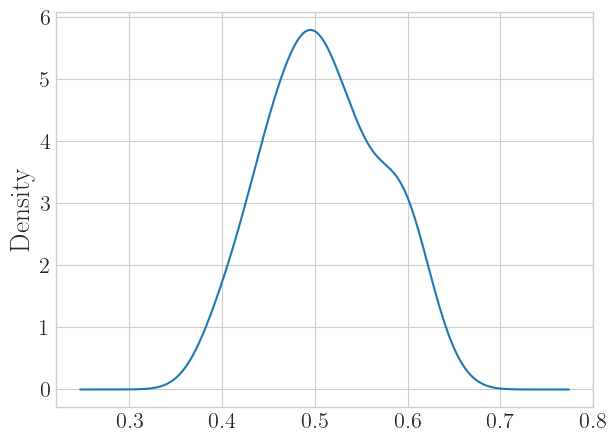

In [8]:
environment.plot.scores_kde(0)
# environment.plot.scores_kde(100)

<Axes: title={'center': 'Population size over 21 time steps'}, xlabel='Step', ylabel='Number of agents'>

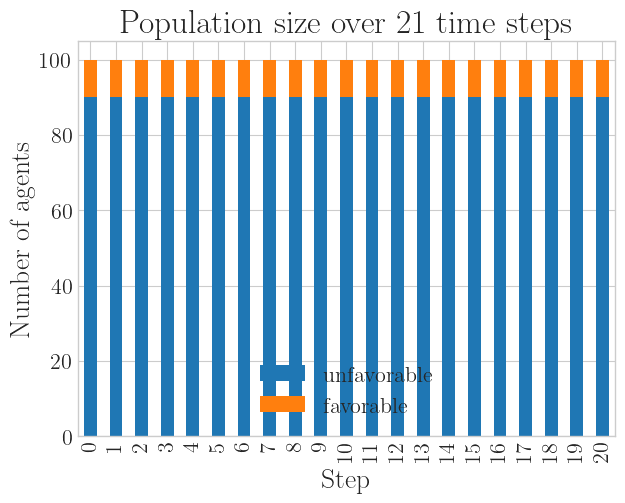

In [9]:
environment.plot.population_size()

In [10]:
environment.success_rate(1, 20)

array([1.        , 1.        , 1.        , 0.88888889, 1.        ,
       0.625     , 0.83333333, 0.66666667, 1.        , 0.69230769,
       0.66666667, 0.83333333, 1.        , 0.6       , 0.52631579,
       1.        , 1.        , 1.        , 1.        ])

In [11]:
environment.threshold_drift(1, 20)

array([-0.00752553,  0.00337305, -0.00240573,  0.00872798, -0.00090585,
        0.01453449,  0.0104253 ,  0.01049887, -0.00377995,  0.0064431 ,
        0.02360928,  0.01323547, -0.02663951,  0.00854484,  0.01745934,
        0.00877593, -0.00635845,  0.00312121, -0.01827345, -0.01088891])

In [12]:
steps_info = environment.steps_info()
steps_info.tail(10)

,n_adapted,n_candidates,favorable_outcomes,success_rate,threshold,threshold_drift,new_agents,new_agents_proba,moving_agent_proba,success_proba
11,90.0,15.0,10.0,0.666667,0.635622,0.023609,10.0,0.01,0.093823,0.651418
12,90.0,12.0,10.0,0.833333,0.644034,0.013235,10.0,0.00,0.075184,0.906101
13,90.0,4.0,10.0,1.000000,0.626878,-0.026640,10.0,0.02,0.148982,0.021357
14,90.0,15.0,10.0,0.600000,0.632234,0.008545,10.0,0.01,0.155865,0.015287
15,90.0,19.0,10.0,0.526316,0.643272,0.017459,10.0,0.00,0.123417,0.167091
16,90.0,10.0,10.0,1.000000,0.648918,0.008776,10.0,0.00,0.075239,0.904271
17,90.0,9.0,10.0,1.000000,0.644792,-0.006358,10.0,0.00,0.083872,0.812806
18,90.0,10.0,10.0,1.000000,0.646804,0.003121,10.0,0.00,0.055287,0.984753
19,90.0,7.0,10.0,1.000000,0.634985,-0.018273,10.0,0.01,0.098053,0.564365
20,90.0,9.0,10.0,1.000000,0.628071,-0.010889,10.0,0.02,0.098768,0.540296


,success_proba,threshold_drift
success_proba,1.00000,0.72241
threshold_drift,0.72241,1.00000


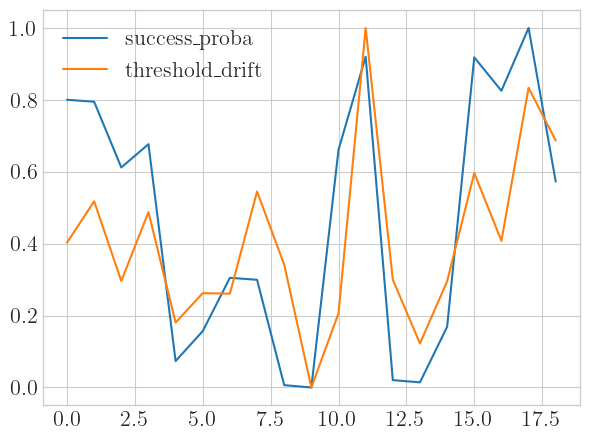

In [13]:
predictions = pd.concat(
    [
        steps_info.success_proba.iloc[:-1].reset_index(drop=True),
        steps_info.threshold_drift.iloc[1:].reset_index(drop=True) * -1,
    ],
    axis=1,
).astype(float)
((predictions - predictions.min()) / (predictions.max() - predictions.min())).iloc[
    :50
].plot.line()
predictions.corr()

In [14]:
steps_info.astype(float).corr().round(2)

,n_adapted,n_candidates,favorable_outcomes,success_rate,threshold,threshold_drift,new_agents,new_agents_proba,moving_agent_proba,success_proba
n_adapted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
n_candidates,NaN,1.00,NaN,-0.92,0.31,0.83,NaN,-0.33,0.16,-0.26
favorable_outcomes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
success_rate,NaN,-0.92,NaN,1.00,-0.18,-0.71,NaN,0.25,-0.36,0.44
threshold,NaN,0.31,NaN,-0.18,1.00,0.11,NaN,-0.96,-0.22,0.20
threshold_drift,NaN,0.83,NaN,-0.71,0.11,1.00,NaN,-0.08,-0.09,0.06
new_agents,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
new_agents_proba,NaN,-0.33,NaN,0.25,-0.96,-0.08,NaN,1.00,0.01,0.01
moving_agent_proba,NaN,0.16,NaN,-0.36,-0.22,-0.09,NaN,0.01,1.00,-0.95
success_proba,NaN,-0.26,NaN,0.44,0.20,0.06,NaN,0.01,-0.95,1.00


In [15]:
environment.agents_info()

,entered_step,n_adaptations,favorable_step,original_score,final_score,n_failures
0,0,5,5.0,0.552311,0.603811,0
1,0,0,0.0,0.599871,0.599871,0
2,0,7,7.0,0.505332,0.651227,1
3,0,1,1.0,0.594853,0.618035,0
4,0,18,18.0,0.442284,0.652290,0
...,...,...,...,...,...,...
295,20,0,NaN,0.505612,NaN,0
296,20,0,NaN,0.501910,NaN,0
297,20,0,NaN,0.604163,NaN,0
298,20,0,NaN,0.426849,NaN,0
